In [1]:
import numpy as np
import pandas as pd
np.random.seed(1)

In [2]:
cd data/

D:\Documents\Tugas\Anaconda\Skripsi_Recommender\example_test\data


In [3]:
names = ['user_id', 'item_id', 'rating']
df = pd.read_csv('reviews_50u_35i_ready.csv', sep=',', names=names)
df.head()

,user_id,item_id,rating
0,1,1,5
1,1,2,5
2,1,4,1
3,1,5,1
4,2,1,5


In [4]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 5., 0., 1., 1.],
       [5., 0., 4., 1., 1.],
       [1., 0., 1., 5., 5.],
       [1., 1., 0., 4., 0.]])

In [5]:
print str(n_users) + ' users'
print str(n_items) + ' items'
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print 'Sparsity: {:4.2f}%'.format(sparsity)

4 users
5 items
Sparsity: 75.00%


In [6]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                       size=1,replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    assert(np.all((train * test) == 0))
    return train, test

In [7]:
train, test = train_test_split(ratings)

In [3]:
from ExplicitMF import ExplicitMF

In [9]:
MF_SGD = ExplicitMF(train, 2, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train mse: 3.618609410275344
Test mse: 3.516394865881794
Iteration: 2
Train mse: 3.602336299290941
Test mse: 3.5215405652540483
Iteration: 5
Train mse: 3.554439000720514
Test mse: 3.536732966677904
Iteration: 10
Train mse: 3.4773890364449653
Test mse: 3.561115190647887
Iteration: 25
	current iteration: 10
Train mse: 3.2641894661801203
Test mse: 3.627713990349136
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 2.9535971981571207
Test mse: 3.7160430979320704
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 2.4265893614254725
Test mse: 3.804277984564445
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 1.506487956552607
Test mse: 3.650649002954692


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, label='Test', linewidth=5)
    
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

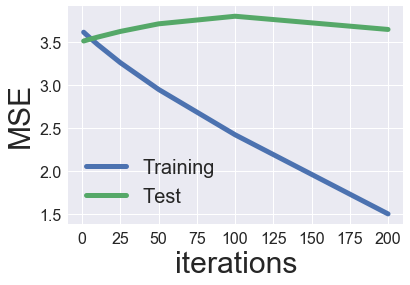

In [11]:
plot_learning_curve(iter_array, MF_SGD)

In [12]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for rate in learning_rates:
    print 'Rate: {}'.format(rate)
    MF_SGD = ExplicitMF(train, n_factors=2, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:        
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print 'New optimal hyperparameters'
        print pd.Series(best_params)

Rate: 1e-05
New optimal hyperparameters
learning_rate                                                1e-05
model            <ExplicitMF.ExplicitMF instance at 0x000000000...
n_iter                                                           1
test_mse                                                   4.31551
train_mse                                                  3.17613
dtype: object
Rate: 0.0001
Rate: 0.001
Rate: 0.01
New optimal hyperparameters
learning_rate                                                 0.01
model            <ExplicitMF.ExplicitMF instance at 0x000000000...
n_iter                                                           1
test_mse                                                   3.74807
train_mse                                                  3.82204
dtype: object


In [13]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [2]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print 'Factors: {}'.format(fact)
    for reg in regularizations:
        print 'Regularizations: {}'.format(reg)
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                           user_fact_reg=reg, item_fact_reg=reg,\
                           user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test,\
                                        learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print 'New optimal hyperparameters'
            print pd.Series(best_params)

Factors: 2
Regularizations: 0.001
New optimal hyperparameters
model        <ExplicitMF.ExplicitMF instance at 0x000000000...
n_factors                                                    2
n_iter                                                     200
reg                                                      0.001
test_mse                                               1.71754
train_mse                                              1.06471
dtype: object
Regularizations: 0.01
Regularizations: 0.1
Regularizations: 1.0


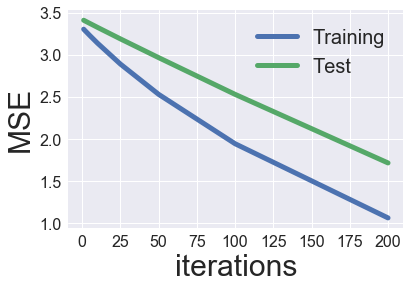

In [14]:
plot_learning_curve(iter_array, best_params['model'])

In [15]:
print 'Best regularization: {}'.format(best_params['reg'])
print 'Best latent factors: {}'.format(best_params['n_factors'])
print 'Best iterations: {}'.format(best_params['n_iter'])

Best regularization: 0.001
Best latent factors: 2
Best iterations: 200


In [19]:
best_sgd_model = ExplicitMF(ratings, n_factors=2, learning='sgd', \
                            item_fact_reg=0.001, user_fact_reg=0.001, \
                            user_bias_reg=0.001, item_bias_reg=0.001)
best_sgd_model.train(200, learning_rate=0.01)

In [20]:
best_sgd_model.item_vecs

array([[ 0.90998808, -1.00154913],
       [ 0.85788531, -0.89118291],
       [ 0.3216885 , -1.11450449],
       [-0.81248112,  1.22473547],
       [-1.12746689,  0.89871308]])

In [21]:
best_sgd_model.user_vecs

array([[ 1.47868693, -0.42541134],
       [ 1.16749823, -0.64959742],
       [-0.58802807,  1.56414819],
       [-0.10761304,  1.52321668]])

In [17]:
item_vecs = np.matrix([[ 0.90998808, -1.00154913],
       [ 0.85788531, -0.89118291],
       [ 0.3216885 , -1.11450449],
       [-0.81248112,  1.22473547],
       [-1.12746689,  0.89871308]])

user_vecs = np.matrix([[ 1.47868693, -0.42541134],
       [ 1.16749823, -0.64959742],
       [-0.58802807,  1.56414819],
       [-0.10761304,  1.52321668]])

In [22]:
user_pref1 = user_vecs[0, :].dot(item_vecs.T)
print(user_pref)

[[ 1.77165784  1.64766311  0.94979943 -1.72242157 -2.04949329]]


In [23]:
user_pref2 = user_vecs[1, :].dot(item_vecs.T)
print(user_pref2)

[[ 1.7130132   1.5804897   1.09955    -1.74415527 -1.9001173 ]]


In [24]:
user_pref3 = user_vecs[2, :].dot(item_vecs.T)
print(user_pref3)

[[-2.10166979 -1.89840278 -1.93241205  2.39342947  2.06870262]]


In [25]:
user_pref4 = user_vecs[3, :].dot(item_vecs.T)
print(user_pref4)

[[-1.62350292 -1.44978432 -1.73224971  1.95297106  1.49026489]]


In [10]:
best_sgd_model = ExplicitMF(ratings, n_factors=2, learning='sgd', \
                            item_fact_reg=0, user_fact_reg=0, \
                            user_bias_reg=0, item_bias_reg=0)
best_sgd_model.train(1, learning_rate=0.01)

In [31]:
n_factors = 2
learning_rate = 0.01
n_iter = 200

sample_row, sample_col = ratings.nonzero()
n_samples = len(sample_row)
user_vecs = np.random.normal(scale=1./n_factors,\
                                    size=(n_users, n_factors))
item_vecs = np.random.normal(scale=1./n_factors,
                                    size=(n_items, n_factors))
print(user_vecs)
print(item_vecs)

def predict(u, i):
    """ Single user and item prediction."""
    pred = user_vecs[u, :].dot(item_vecs[i, :].T)
    return pred

ctr = 1
while ctr <= n_iter:
    print('iter : {}'.format(ctr))
    training_indices = np.arange(n_samples)
    np.random.shuffle(training_indices)
    for idx in training_indices:
            #print('idx : {}'.format(idx))
            u = sample_row[idx]
            i = sample_col[idx]
            prediction = predict(u, i)
            #print('pred : {}'.format(prediction))
            e = (ratings[u,i] - prediction) # error
            #print('error : {}'.format(e))

            #Update latent factors
            user_vecs[u, :] += learning_rate * \
                                    (e * item_vecs[i, :])
            #print('user_vecs : {}'.format(user_vecs[u, :]))
            
            item_vecs[i, :] += learning_rate * \
                                    (e * user_vecs[u, :])
            #print('item_vecs : {}'.format(item_vecs[i, :]))
            
    #print(user_vecs)
    #print(item_vecs)
    print(user_vecs[0,:])
    print(item_vecs[0,:])
    print(' ')
    ctr += 1
    
print(user_vecs)
print(item_vecs)
    


[[ 0.22100714 -0.07477301]
 [ 0.48409094 -0.34540953]
 [-0.85674668  1.03331293]
 [-0.6672236   0.33917952]]
[[ 0.52467147  0.36995107]
 [-0.22816701 -1.10413429]
 [ 0.39209189  0.12720585]
 [ 0.1457897  -0.08053978]
 [-0.03499257  0.01540185]]
iter : 1
[ 0.23535429 -0.11071147]
[0.5446027  0.36392483]
 
iter : 2
[ 0.25061299 -0.14653538]
[0.56730788 0.3574723 ]
 
iter : 3
[ 0.26668847 -0.18092579]
[0.59124227 0.35131403]
 
iter : 4
[ 0.28398401 -0.2158406 ]
[0.61808777 0.34771242]
 
iter : 5
[ 0.3009224  -0.24824287]
[0.64735186 0.3439067 ]
 
iter : 6
[ 0.31769068 -0.27869434]
[0.67956882 0.33714157]
 
iter : 7
[ 0.33585677 -0.30934669]
[0.71336348 0.33449507]
 
iter : 8
[ 0.35420215 -0.3379011 ]
[0.74940184 0.33245443]
 
iter : 9
[ 0.37372867 -0.36404521]
[0.78653654 0.32861063]
 
iter : 10
[ 0.39459223 -0.39084994]
[0.82585325 0.32925516]
 
iter : 11
[ 0.417485  -0.4156317]
[0.86615647 0.33116411]
 
iter : 12
[ 0.44130595 -0.43657578]
[0.90841829 0.33195967]
 
iter : 13
[ 0.46621159

[2.37031873 0.33943376]
[1.99874505 0.58314429]
 
iter : 152
[2.37004992 0.33940295]
[1.99952379 0.5816305 ]
 
iter : 153
[2.36962681 0.33926166]
[2.00042492 0.58054938]
 
iter : 154
[2.36922806 0.33914737]
[2.00097702 0.57905536]
 
iter : 155
[2.36879784 0.33896555]
[2.00164314 0.57747432]
 
iter : 156
[2.36863983 0.33885337]
[2.00258382 0.57627521]
 
iter : 157
[2.3683491  0.33873014]
[2.00312377 0.57399421]
 
iter : 158
[2.36792181 0.33852271]
[2.00357034 0.57247414]
 
iter : 159
[2.36785896 0.3384957 ]
[2.00445007 0.57031969]
 
iter : 160
[2.36763237 0.3383912 ]
[2.00515186 0.56806321]
 
iter : 161
[2.36733856 0.33830343]
[2.005974   0.56627493]
 
iter : 162
[2.36695097 0.33815212]
[2.00658812 0.56523294]
 
iter : 163
[2.36657563 0.33794325]
[2.00696278 0.56375283]
 
iter : 164
[2.36640375 0.33782273]
[2.00780329 0.56258908]
 
iter : 165
[2.36605833 0.33767332]
[2.00837206 0.56141774]
 
iter : 166
[2.36584376 0.33756513]
[2.0090058  0.56004068]
 
iter : 167
[2.36562695 0.33747408]


In [7]:
best_sgd_model2 = ExplicitMF(ratings, n_factors=2, learning='sgd', \
                            item_fact_reg=0.001, user_fact_reg=0.001, \
                            user_bias_reg=0.001, item_bias_reg=0.001)
best_sgd_model2.train(200, learning_rate=0.01)

In [8]:
best_sgd_model2.item_vecs

array([[-0.53912869,  0.88673098],
       [ 0.29000684,  0.92943346],
       [-0.71064615,  0.49456851],
       [ 0.79709565, -1.57474573],
       [ 0.4230077 , -1.63085951]])

In [9]:
best_sgd_model2.user_vecs

array([[ 0.45340535,  1.31310708],
       [-0.79025066,  0.67372707],
       [ 0.60038975, -1.82746333],
       [ 1.0363758 , -1.22600981]])

In [32]:
#cosine similarity
item_vecs = np.matrix([[ 0.90998808, -1.00154913],
       [ 0.85788531, -0.89118291],
       [ 0.3216885 , -1.11450449],
       [-0.81248112,  1.22473547],
       [-1.12746689,  0.89871308]])

In [30]:
item_vecs = np.matrix([[ 1, 0.5],
       [ 2, 0.5],
       [ 3, 0.5],
       [ 0.5, 1],
       [ 0.5, 2]])

In [33]:
sgd_sim = np.zeros((5, 5))

sim = item_vecs.dot(item_vecs.T)
print(sim)
norms = np.array([np.sqrt(np.diagonal(sim))])
print(norms)
sgd_sim = sim / norms / norms.T
print(sgd_sim)

[[ 1.83117897  1.67322887  1.4089637  -1.96598088 -1.92608673]
 [ 1.67322887  1.53017418  1.26919919 -1.78847894 -1.76815502]
 [ 1.4089637   1.26919919  1.34560375 -1.62633901 -1.3643129 ]
 [-1.96598088 -1.78847894 -1.62633901  2.16010254  2.01673135]
 [-1.92608673 -1.76815502 -1.3643129   2.01673135  2.07886679]]
[[1.35321061 1.2370021  1.16000162 1.46972873 1.44182759]]
[[ 1.          0.99958451  0.89758547 -0.98850008 -0.98718174]
 [ 0.99958451  1.          0.88450595 -0.98373067 -0.99137183]
 [ 0.89758547  0.88450595  1.         -0.95392735 -0.81572178]
 [-0.98850008 -0.98373067 -0.95392735  1.          0.95169445]
 [-0.98718174 -0.99137183 -0.81572178  0.95169445  1.        ]]


In [34]:
print(np.diagonal(sim))

[1.83117897 1.53017418 1.34560375 2.16010254 2.07886679]


In [35]:
print(np.sqrt(np.diagonal(sim)))

[1.35321061 1.2370021  1.16000162 1.46972873 1.44182759]


In [36]:
print(np.array([np.sqrt(np.diagonal(sim))]))

[[1.35321061 1.2370021  1.16000162 1.46972873 1.44182759]]


In [37]:
print(sim / norms)

[[ 1.35321061  1.35264837  1.21462219 -1.3376488  -1.33586481]
 [ 1.23648814  1.2370021   1.09413571 -1.2168769  -1.22632903]
 [ 1.0412006   1.02602833  1.16000162 -1.10655727 -0.94623859]
 [-1.45282697 -1.44581723 -1.40201444  1.46972873  1.39873267]
 [-1.42334587 -1.42938725 -1.17613017  1.3721793   1.44182759]]


In [38]:
print(sim / norms / norms.T)

[[ 1.          0.99958451  0.89758547 -0.98850008 -0.98718174]
 [ 0.99958451  1.          0.88450595 -0.98373067 -0.99137183]
 [ 0.89758547  0.88450595  1.         -0.95392735 -0.81572178]
 [-0.98850008 -0.98373067 -0.95392735  1.          0.95169445]
 [-0.98718174 -0.99137183 -0.81572178  0.95169445  1.        ]]


In [39]:
print(norms.T)

[[1.35321061]
 [1.2370021 ]
 [1.16000162]
 [1.46972873]
 [1.44182759]]


In [56]:
#cosine similarity
my_ratings = np.matrix([[0, 5, 3, 0, 0]])
print(my_ratings)

[[0 5 3 0 0]]


In [57]:
my_pref = my_ratings.dot(item_vecs)
print(my_pref)

[[ 5.25449205 -7.79942802]]


In [58]:
my_recommendation = my_pref.dot(item_vecs.T)
print(my_recommendation)

[[ 12.59303548  11.4584685   10.38280721 -13.82141173 -12.93371379]]
